# Datapaper plots

1. field_location.png Modis moa Inset map, ant in corner, icestreams scale, square of common border, include flow route,
2. geophysics_overview.png Map of all data presented
3. historic_channel.png Historic landsat images
4. thickness_surfacecolour.png Profile depth
5. Four square = imagery, surface, bed&surface, change
6. 3D view of channel
7. radarlines 
8. channel_meander.png meander
11. ApRES include stress
9. Icesat1/REMA
10. Icesat2


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio
from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points

In [2]:
new_gpr = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')
old_gpr = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/1516_gprlines.shp')
old_gpr['camp'] = 'KIS2' 
bed_gdf = pd.concat([new_gpr,old_gpr])
gdf = bed_gdf[bed_gdf.camp =='KIS2'].copy()
ngpr = new_gpr[new_gpr.camp =='KIS2'].copy()

In [3]:
x_old = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydistold_points_x.npy')
y_old = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydistold_points_y.npy')
it_old = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydistold_ice_thickn.npy')


In [4]:
# x_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_points_x.npy')
# y_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_points_y.npy')
# it_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_ice_thickn.npy')
# ib_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_icebase.npy')

In [5]:
x_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_points_x.npy')
y_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_points_y.npy')
it_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_ice_thickn.npy')
ib_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_icebase.npy')

In [6]:
#load REMA
nid1 = 159202
nid2 = 131226
df = gpd.read_file('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/REMA_Strip_Index_Rel1/REMA_Strip_Index_Rel1.shp')
path = f"/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_{nid1}-{nid2}_diff.tif"
# /Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_159202-131226_diff.tif
f = df.loc[nid1].acquisitio
t =df.loc[nid2].acquisitio
duration = (pd.to_datetime(t)-pd.to_datetime(f)).days/365.25
with rio.open(path) as image:
    im = image.read(1)
    im[im==-9999] = np.nan
    im = im / duration
    extent_REMAdiff = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
with rio.open('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0_dem.tif') as image:
    extent_REMA = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_REMA = image.read(1)

In [7]:
df.loc[nid1].fileurl

'http://data.pgc.umn.edu/elev/dem/setsm/REMA/geocell/v1.0/2m/s83w153/SETSM_WV02_20121224_103001001D86CA00_103001001D886000_seg1_2m_v1.0.tar.gz'

In [8]:
direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan'

xv = np.load(direc + 'x_grid' +'.npy')
yv = np.load(direc + 'y_grid' +'.npy')
thickness_interpolated = np.load(direc +'ice_thickness'+'.npy')
extent_l2l = np.load(direc +'extent.npy')
ice_base = np.load(direc +'_ice_base.npy')


In [9]:
x = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')
y = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')

In [10]:
xmin, xmax, ymin, ymax = extent_l2l

In [11]:
xmin = -382700

In [12]:
x_i = np.argwhere((x>xmin) & (x< xmax)).flatten()[0]
x_j = np.argwhere((x>xmin) & (x< xmax)).flatten()[-1]
y_i = np.argwhere((y>ymin) & (y< ymax)).flatten()[0]
y_j = np.argwhere((y>ymin) & (y< ymax)).flatten()[-1]

In [13]:
x_c = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')[x_i:x_j]
y_c = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')[y_i:y_j]

In [14]:
xv_REMA, yv_REMA = np.meshgrid(x_c, y_c)

In [15]:
im_REMA_d = im_REMA[y_i:y_j,x_i:x_j]
im_REMA_d[im_REMA_d==-99.99] = np.nan
im_REMA_c = im_REMA_d*100
del im_REMA_d

## 1. REMA bullseye with contours of channel

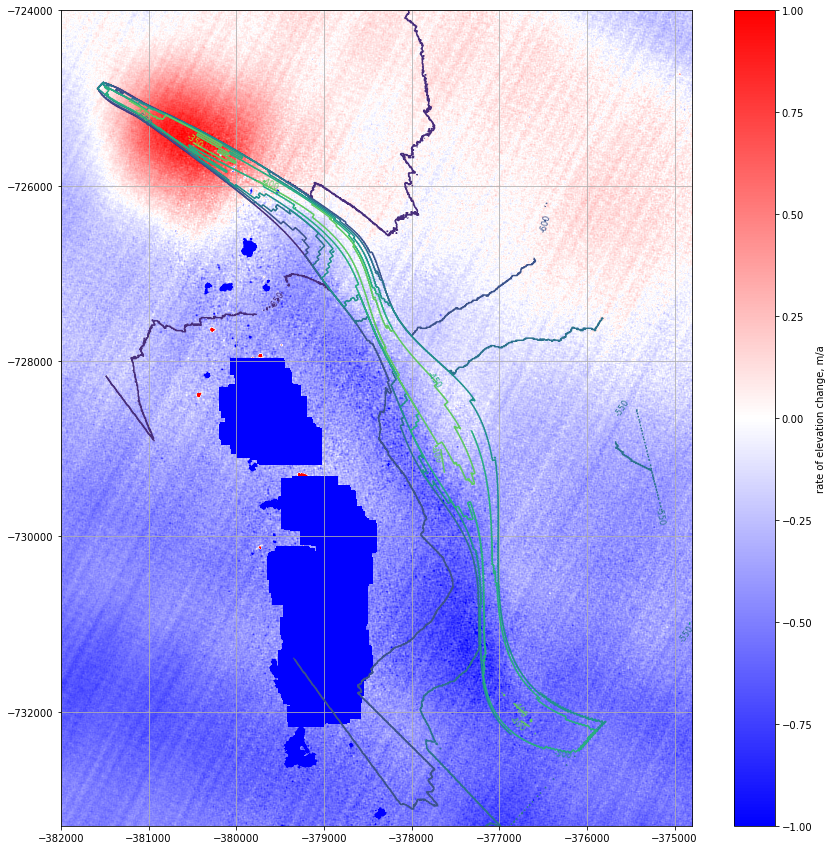

In [16]:

#rema
v=[0,1]    

extent_REMA1 = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
plt.figure(figsize=(15,15))
# GyRd = plt.cm.get_cmap('RdGy').reversed()
plt.imshow(im,extent=extent_REMAdiff, vmin=-1,vmax=1,cmap='bwr')
cb = plt.colorbar()
cb.set_label('rate of elevation change, m/a')

# manual_locations = [(-380000, -727585),(-378000, -731200), (-380250,727650), (-377116, -729519), (-377640, -731742),  (-377470,-728870), (2.4, 1.7)]
manual_locations = [(-380000, -727585),(-378000, -731200),(-377640, -731742)]

CS = plt.contour(xv[:,500:],yv[:,500:],ice_base[:,500:])
plt.clabel(CS, inline=1, fontsize=8, fmt='%i')


# cb2 = plt.colorbar()
# cb2.set_label('Elevation of ice underside, m')
plt.xlim([-382000, -374800])
plt.ylim([-733300,-724000])
plt.grid()
# plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/bullseye_n_basecontour.png')
plt.show()

## 2. colors of chan with contours of surf

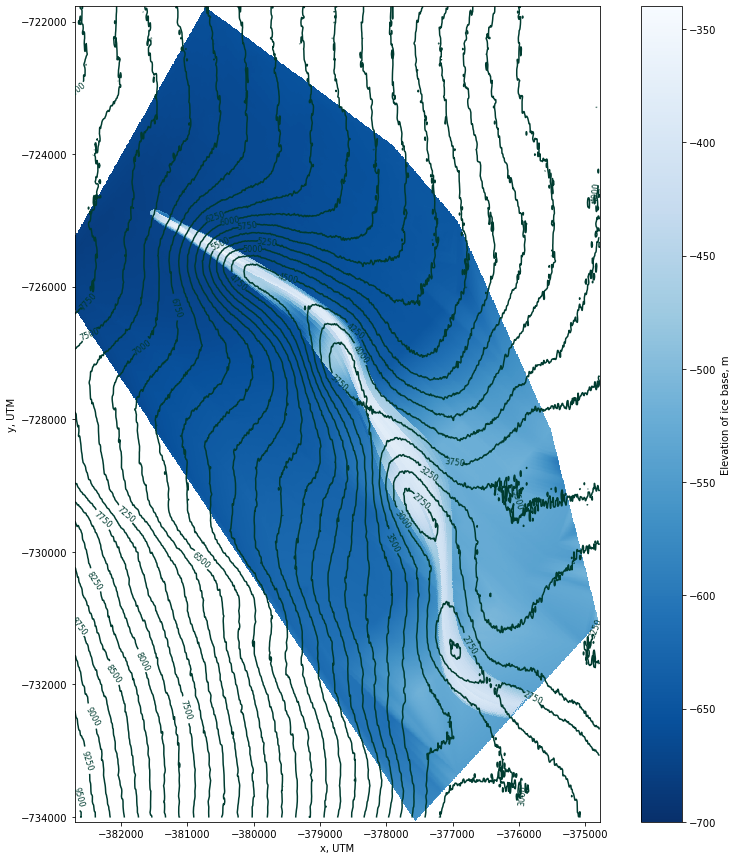

In [17]:
jj = 40

plt.figure(figsize=(15,15))

CS =  plt.contour(xv_REMA[::jj],yv_REMA[::jj],im_REMA_c[::jj],30,vmin=25,vmax=80, cmap='BrBG')
plt.clabel(CS, inline=1, fontsize=8, fmt='%i')

v = [-750,-350]
plt.imshow(ice_base,extent=extent_l2l,cmap='Blues_r',vmin=-700,vmax=-340)
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
cb = plt.colorbar()
cb.set_label('Elevation of ice base, m')
plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/basecolour_surfcontour.png')
# plt.title('Colored base of ice with contours of surface topography')

#zoom in on channel head-ish
# plt.xlim([-381500, -379800])
# plt.ylim([-726000, -724000])

plt.xlabel('x, UTM')
plt.ylabel('y, UTM')

plt.show()

## 2b. colors of chan with contours of surf --- Zoom on head of channel

In [33]:
# jj = 40

# plt.figure(figsize=(15,15))

# CS =  plt.contour(xv_REMA[::jj],yv_REMA[::jj],im_REMA_c[::jj],30)
# plt.clabel(CS, inline=1, fontsize=8, fmt='%i')

# v = [-750,-350]
# plt.imshow(ice_base,extent=extent_l2l,cmap='gist_rainbow',vmin=-700,vmax=-330)


# cb = plt.colorbar()
# cb.set_label('Elevation of ice base, m')

# plt.plot( gdf_mid.x,gdf_mid.y,label='interpolated channel')
# plt.plot( gdf_mid.x.iloc[39],gdf_mid.y.iloc[39],'b1',markeredgecolor='w',label="channel low",markersize=15,markeredgewidth=2)
# plt.plot(points_x_surveyed[10,:],points_y_surveyed[10,:],'x',label="19-20 surveyed points")

# plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/basecolour_surfcontour_zoomonhead.png')
# # plt.title('Colored base of ice with contours of surface topography')
# plt.xlabel('x, UTM')
# plt.ylabel('y, UTM')

# plt.show()

## 3. thickness over length

In [25]:
it = it_new[50,:]
ib = ib_new[50,:]
x = x_new[50,:]
y = y_new[50,:]
mid = pd.DataFrame({'x': x,'y':y,'ice_thickn':it,'ice_base':ib})

points = [Point(xy) for xy in zip(mid.x,mid.y)]
gdf_mid = gpd.GeoDataFrame(mid,geometry=points,crs="EPSG:3031")

In [26]:
points_x_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_points_x_channel.npy')
points_y_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_points_y_channel.npy') 
ice_thickn_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_ice_thickn_channel.npy')
base_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_bed_channel.npy')

In [27]:
# plt.plot(x,np.mean(ib_new[5:15,:],0))

In [28]:
import pickle
with open('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/shapefiles/bullseye.pkl', "rb") as poly_file:
    bullseye = pickle.load(poly_file)

In [29]:
bullseye_array = np.array(bullseye.exterior.coords.xy )

In [30]:
gdf_mid.geometry

0       POINT (-381547.701 -724861.783)
1       POINT (-381545.939 -724863.216)
2       POINT (-381544.174 -724864.644)
3       POINT (-381542.404 -724866.065)
4       POINT (-381540.631 -724867.481)
                     ...               
4396    POINT (-375989.707 -732313.948)
4397    POINT (-375986.304 -732314.392)
4398    POINT (-375982.893 -732314.832)
4399    POINT (-375979.476 -732315.269)
4400    POINT (-375976.053 -732315.702)
Name: geometry, Length: 4401, dtype: geometry

In [31]:
gdf_mid['in_meltzone'] = gdf_mid.geometry.intersects(bullseye)
gdf_mz = gdf_mid[gdf_mid.in_meltzone==True].copy()

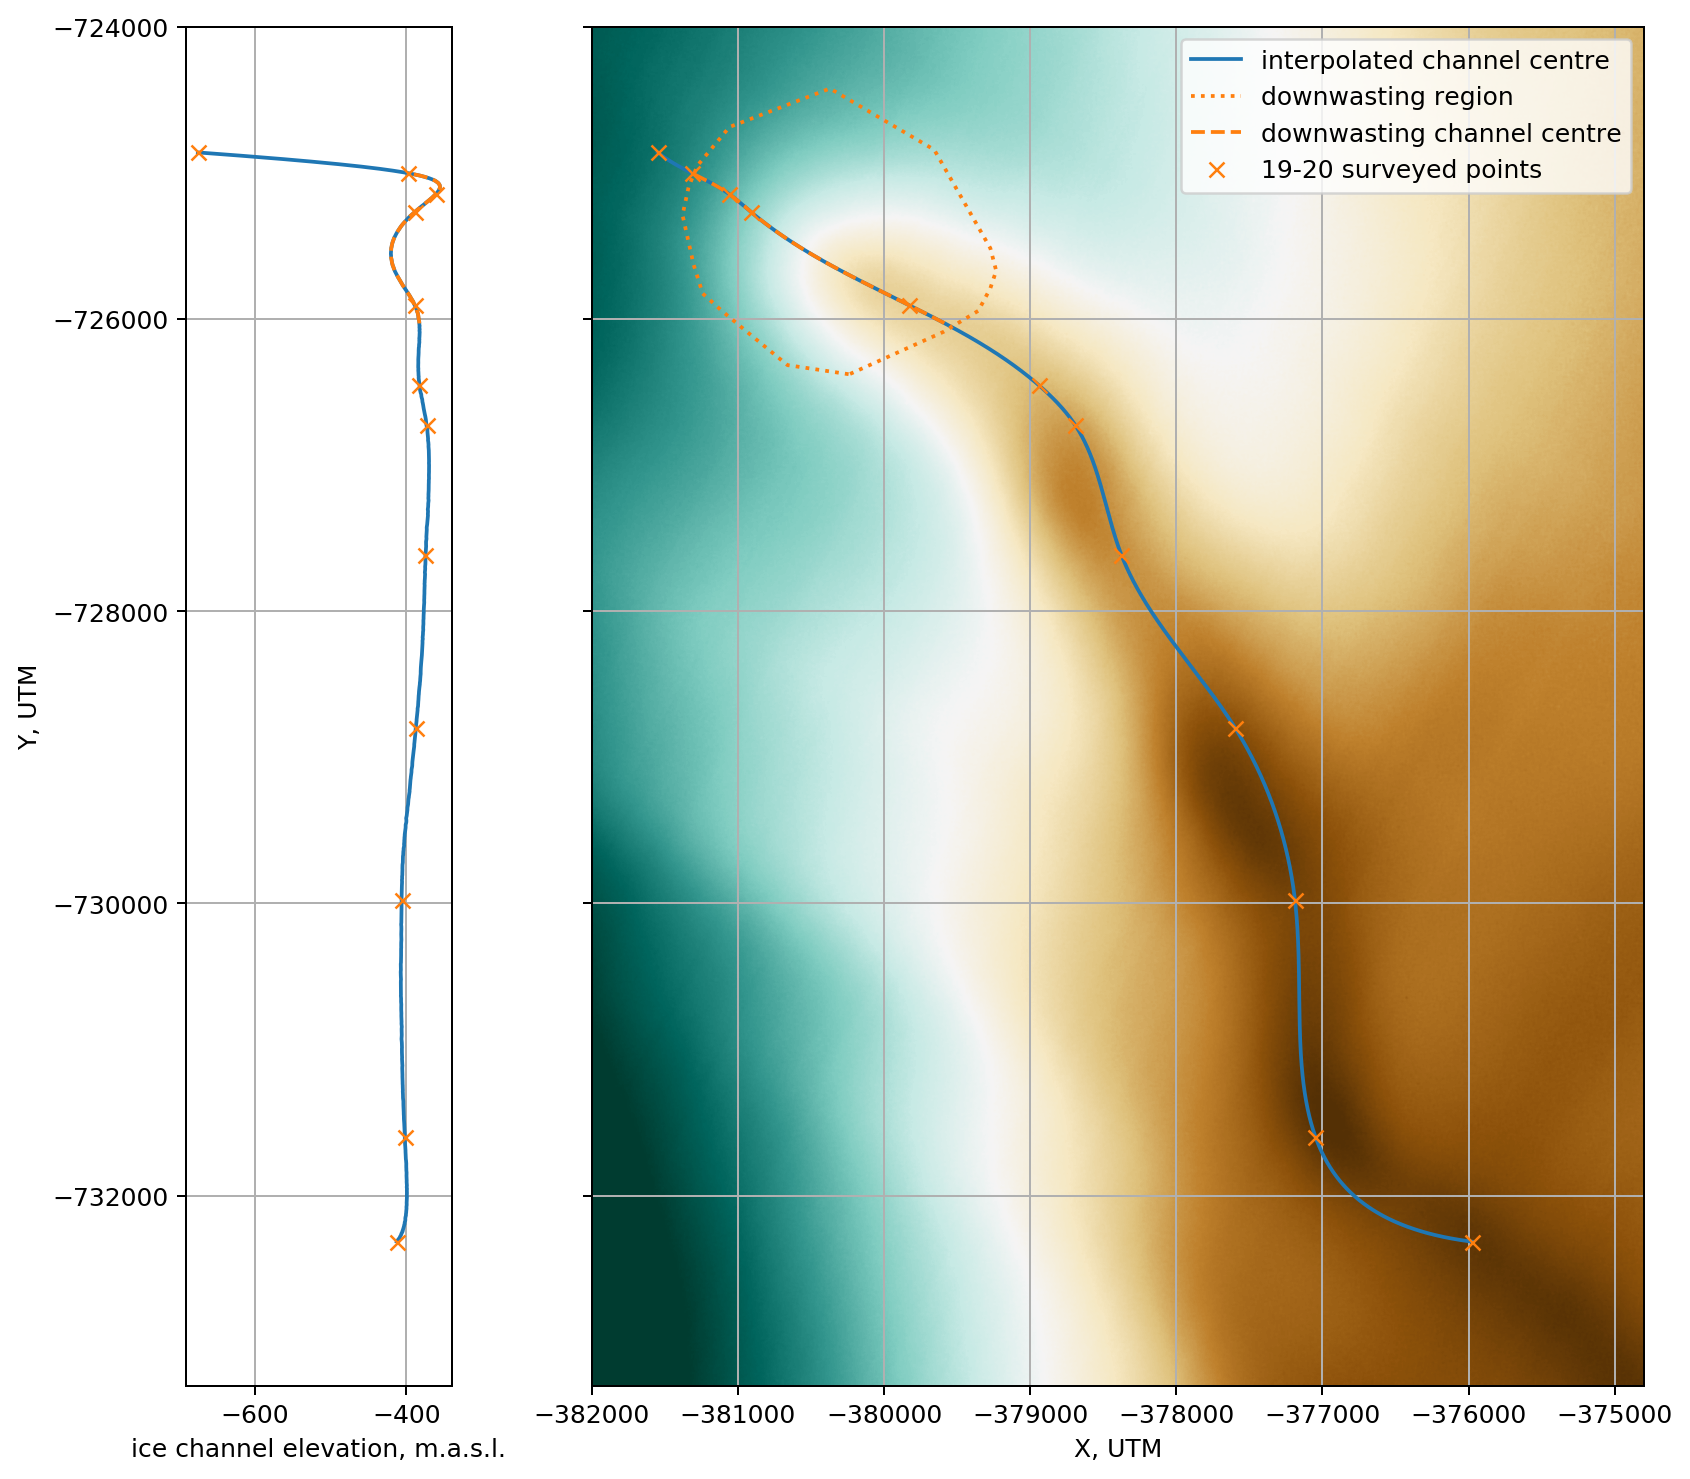

In [32]:
# %matplotlib qt
#  fug, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[2, 3]},figsize=(6,6),dpi=180)#rema

fig, (ax1, ax2) = plt.subplots(1,2, sharey='row',gridspec_kw = {'width_ratios':[1, 4]},
                               figsize=(10.5,10),dpi=180)#rema ,constrained_layout=True

ax2.imshow(im_REMA,extent=extent_REMA,vmin=25,vmax=80, cmap='BrBG')
ax2.plot( gdf_mid.x,gdf_mid.y,label='interpolated channel centre')
# ax2.plot( gdf_mid.x.iloc[39],gdf_mid.y.iloc[39],'b1',label="downwasting centre",markersize=15,markeredgewidth=2)
ax2.plot(bullseye_array[0],bullseye_array[1],':',label="downwasting region",markersize=15,markeredgewidth=2,color='tab:orange')
ax2.plot(gdf_mz.x,gdf_mz.y,'--',label="downwasting channel centre",markersize=15,markeredgewidth=2,color='tab:orange')
ax2.plot(points_x_surveyed[50,:],points_y_surveyed[50,:],'x',label="19-20 surveyed points")
ax2.set_xlim([-382000, -374800])
ax2.set_ylim([-733300,-724000])
ax2.grid()
ax2.set_xlabel('X, UTM')
ax2.legend()
# plt.contour(xv,yv,surf_out-thickness_interpolated,linewidths=0.75)


ax1.plot(gdf_mid.ice_base,gdf_mid.y)
ax1.plot(base_surveyed[50,:],points_y_surveyed[50,:],'x',label="19-20 surveyed points")
# ax1.plot( gdf_mid.ice_base.iloc[39],gdf_mid.y.iloc[39],'b1',label="downwasting centre",markersize=15,markeredgewidth=2)
ax1.plot(gdf_mz.ice_base,gdf_mz.y,'--',label="downwasting channel centre",markersize=15,markeredgewidth=2,color='tab:orange')
# ax1.set_xlim([400, 480])
ax1.set_ylim([-733300,-724000])
ax1.set_ylabel('Y, UTM')
ax1.set_xlabel('ice channel elevation, m.a.s.l.')

ax1.grid()
fig.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/thickness_surfacecolour.png')
fig.show()



## 4) base contours with surface colour

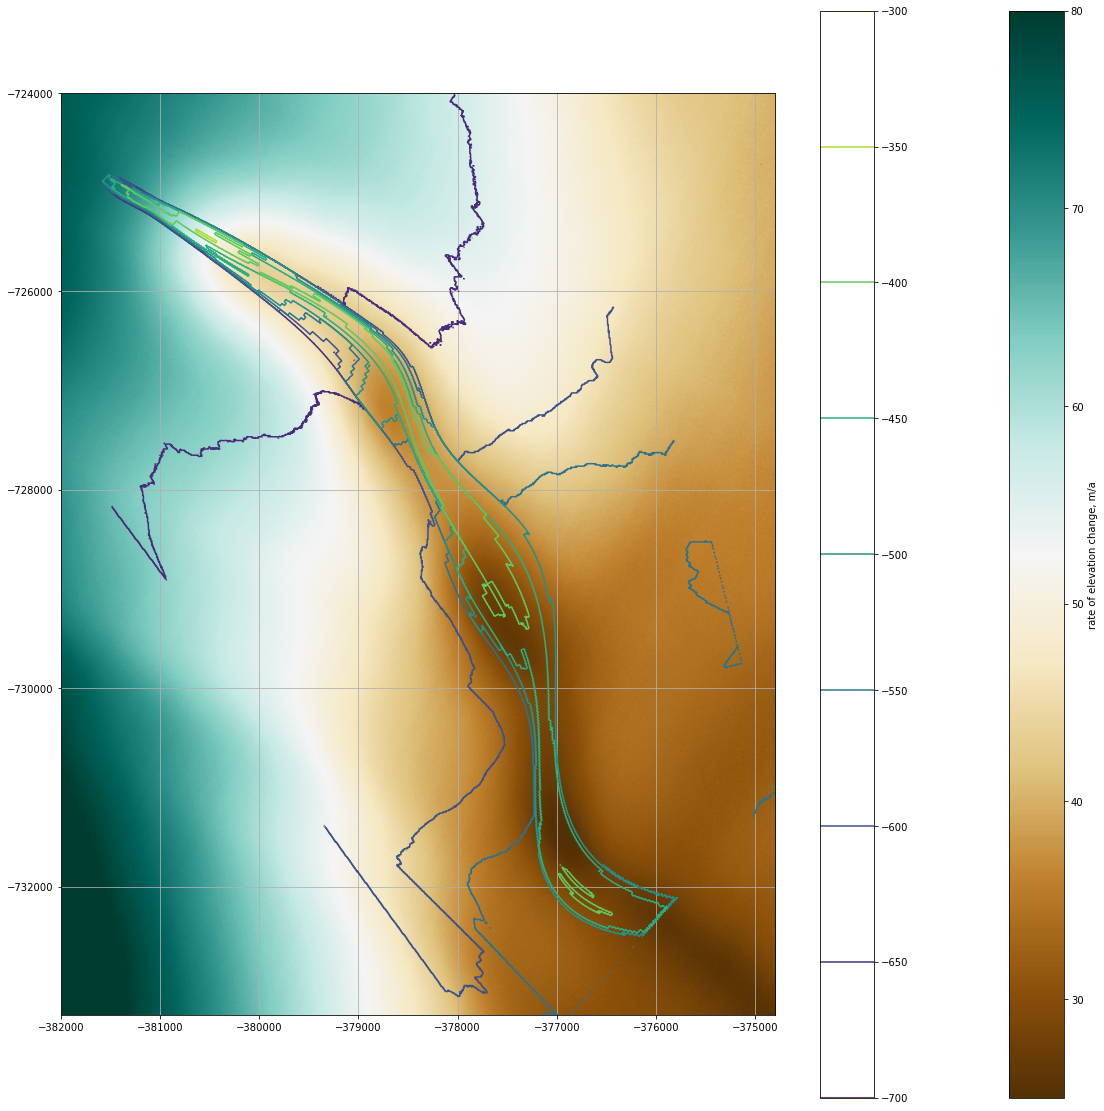

In [18]:
#rema

plt.figure(figsize=(20,20))
plt.imshow(im_REMA,extent=extent_REMA,vmin=25,vmax=80, cmap='BrBG')
cb = plt.colorbar()
cb.set_label('surface elevation (?)')
cb.set_label('rate of elevation change, m/a')
plt.contour(xv[:,500:],yv[:,500:],ice_base[:,500:])

plt.colorbar()
# basecolour_surfcontour
# plt.title('interpolated radarlines over surf topography')
plt.xlim([-382000, -374800])
plt.ylim([-733300,-724000])
plt.grid()
plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/surfcolour_basecontour.png')
plt.show()

# 5) plot radar lines

In [19]:
# bed_gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp').query('camp == "KIS2"  & line_name != "linedownchan" & line_name != "lineback2camp"')
bed_gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp').query('camp == "KIS2"  & line_name != "lineback2camp"')
# bed_gdf = bed_gdf[bed_gdf.camp =='KIS2']
bed_gdf.keys()

Index(['CDP', 'x', 'y', 'DELAY', 'line_name', 'surf', 'SEQnum', 'camp',
       'time_UTC', 'ice_thickn', 'bed', 'geometry'],
      dtype='object')

In [20]:
bed_gdf.line_name.unique()

array(['line7', 'line9', 'line0', 'line10', 'line11', 'line12', 'line13',
       'line14', 'line1', 'line2', 'line3', 'line4', 'line6', 'line7p25',
       'line7p5', 'line7p75', 'line8', 'lineAPREScross', 'lineAPRESdown',
       'linedownchan', 'lineupchan', 'left02', 'left1011', 'left1213',
       'left1415', 'left35', 'left46', 'left79', 'left810', 'right1112',
       'right1314', 'right13', 'right24', 'right68', 'right910', 'line5'],
      dtype=object)

In [21]:
print(bed_gdf[bed_gdf.line_name == 'line8'].x.iloc[0],bed_gdf[bed_gdf.line_name == 'line8'].y.iloc[1])

-383037.7 -725839.8


In [22]:
# im_REMA_filled.shape

NameError: name 'im_REMA_filled' is not defined

In [23]:
# #fill up the background image as it has gaps where clouds were
# im_REMA_filled = im_REMA*100
# # im_REMA_filled[im_REMA_filled==np.nan] = 70
# im_REMA_filled[:14000,:12000] = 70

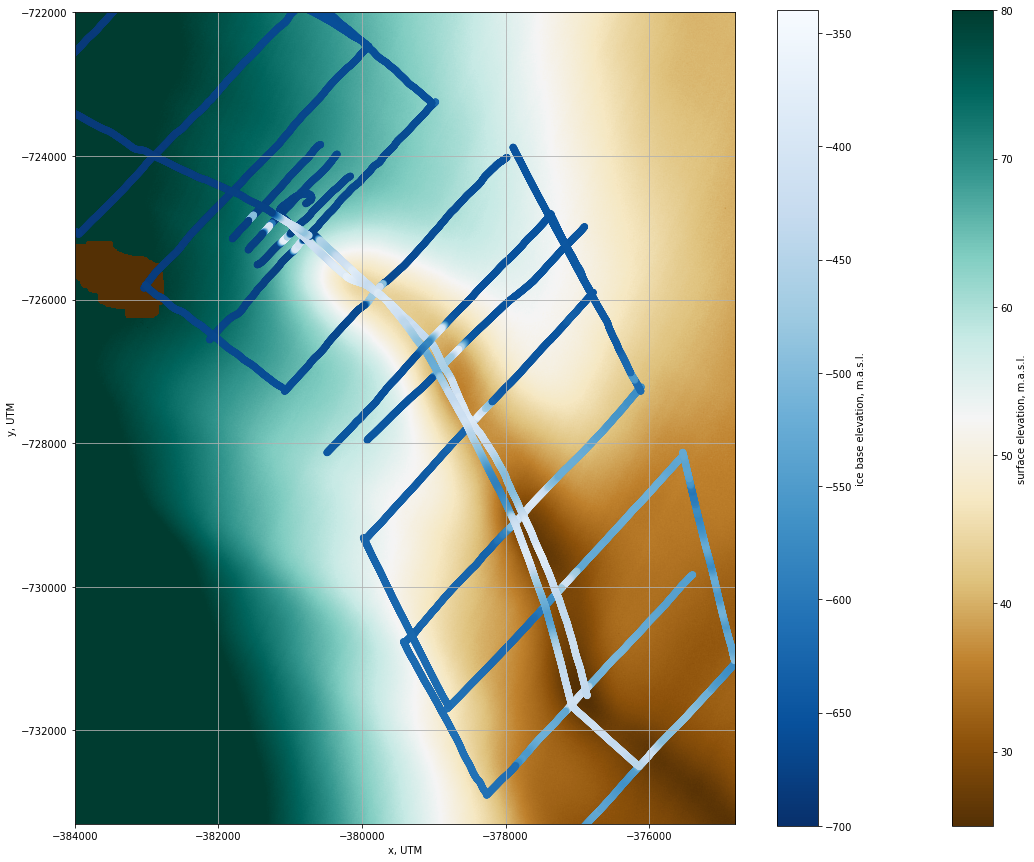

In [33]:
plt.figure(figsize=(18.5,15))
plt.imshow(im_REMA,extent=extent_REMA,vmin=25,vmax=80, cmap='BrBG')
cb = plt.colorbar()
cb.set_label('surface elevation, m.a.s.l.')

plt.scatter(bed_gdf.x, bed_gdf.y, c=bed_gdf.bed,vmin=-700,vmax=-340,cmap='Blues_r')
cb2 = plt.colorbar()
cb2.set_label('ice base elevation, m.a.s.l.')
plt.xlabel('x, UTM')
plt.ylabel('y, UTM')
# basecolour_surfcontour

plt.xlim([-384000, -374800])
plt.ylim([-733300,-722000])
# plt.xlim([-382000,-380000])#tight around inception
# plt.ylim([-726000,-724000])
plt.grid()
plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/radarlines_surfcolour.png')
plt.show()

# calculate stuff for the paper

In [44]:
a = np.array([1,2,3,4,3])
a[a==3] = 33
a

array([ 1,  2, 33,  4, 33])

In [47]:
line35 = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp').query('camp == "KIS2"  & line_name == "left35"')



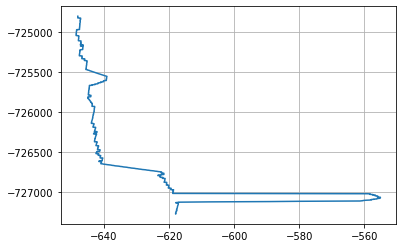

In [50]:
plt.plot(line35.bed,line35.y)
plt.grid()

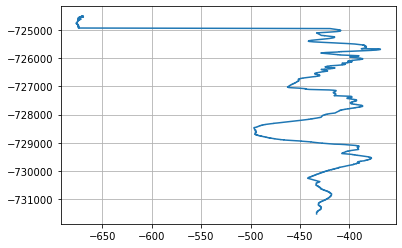

In [51]:
lineAPRESdown = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp').query('camp == "KIS2"  & line_name == "lineAPRESdown"')
plt.plot(lineAPRESdown.bed,lineAPRESdown.y)
plt.grid()

# find out width of channel surf and bed

In [41]:
new_gpr.keys()

Index(['CDP', 'x', 'y', 'DELAY', 'line_name', 'surf', 'SEQnum', 'camp',
       'time_UTC', 'ice_thickn', 'bed', 'geometry'],
      dtype='object')

In [42]:
ll = {} #a dictionary of geodataframes of radarlines over KIS2, ie one gdf for each line.

for line in new_gpr[new_gpr.camp =='KIS2'].line_name.unique().tolist():
    ll[line] = new_gpr[(new_gpr.line_name==line) & (new_gpr.camp=='KIS2')].copy()
    ll[line].sort_values(by='x',inplace=True)
    ll[line].reset_index(drop=True,inplace=True)

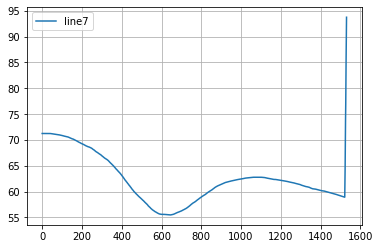

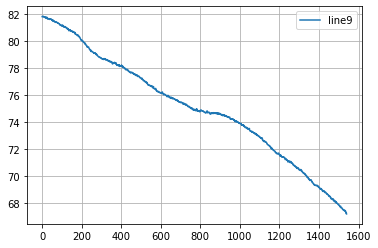

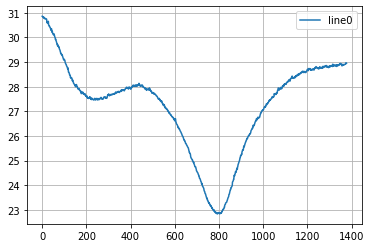

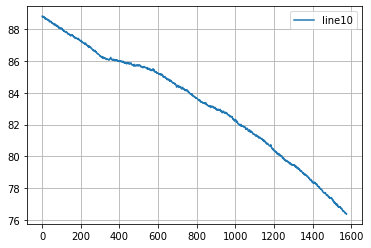

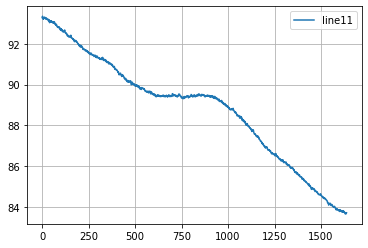

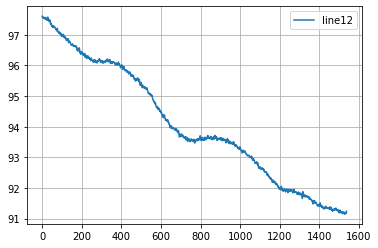

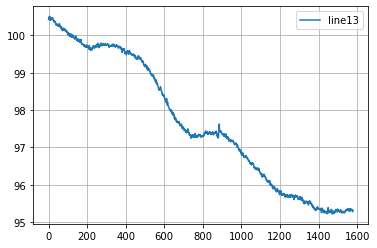

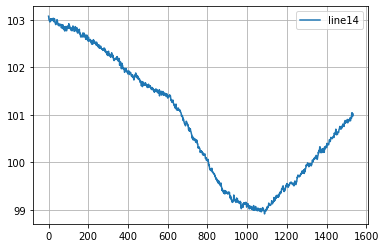

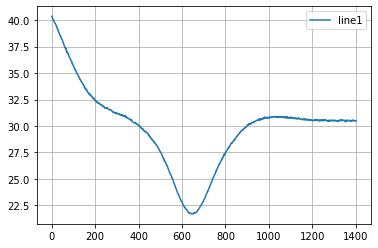

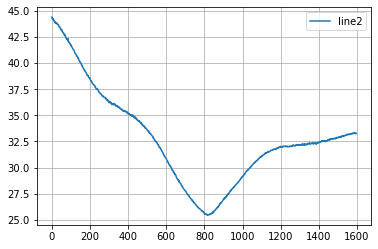

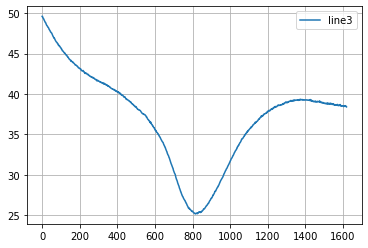

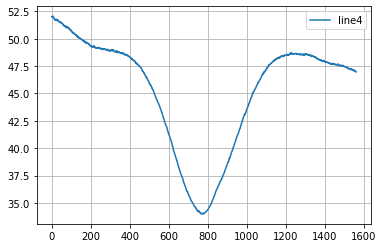

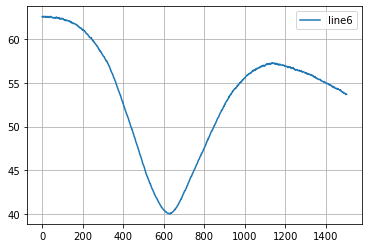

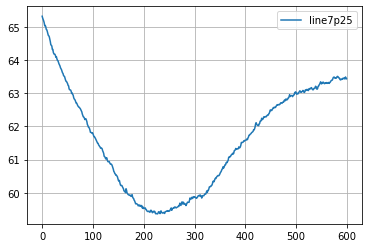

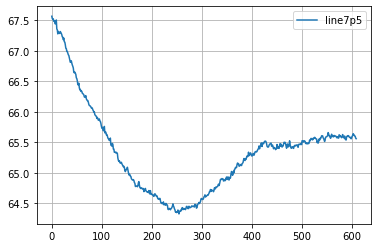

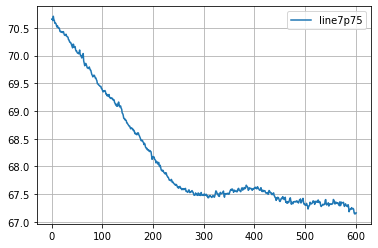

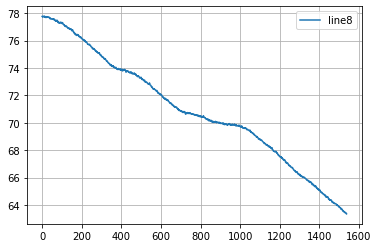

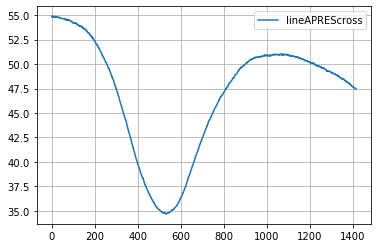

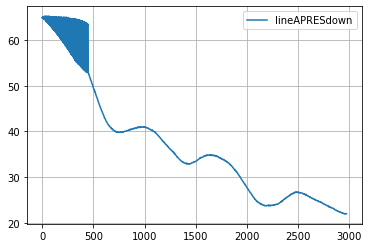

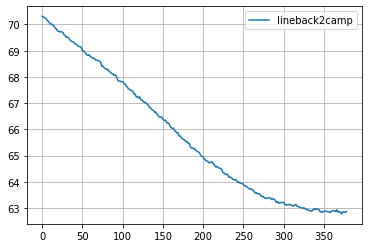

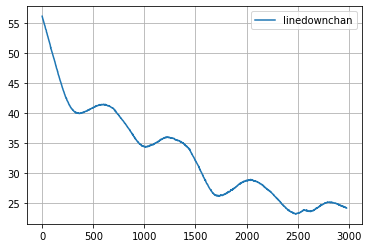

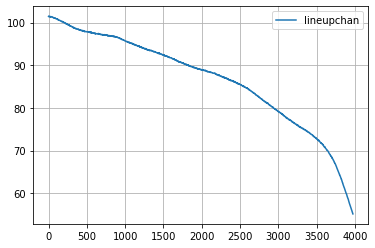

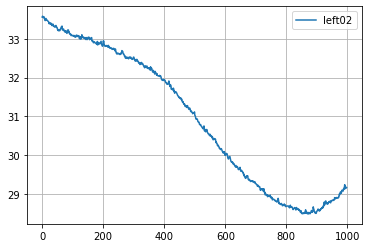

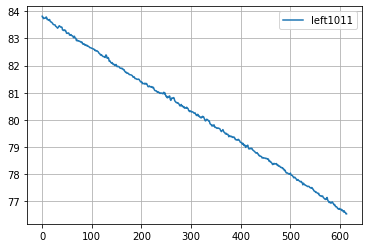

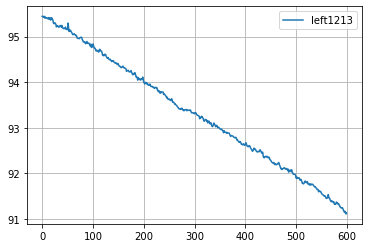

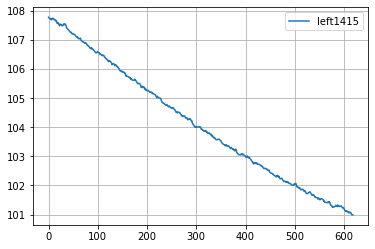

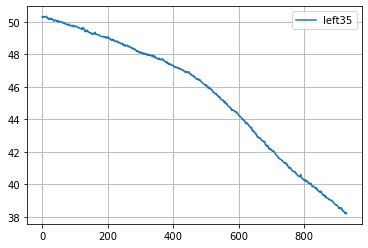

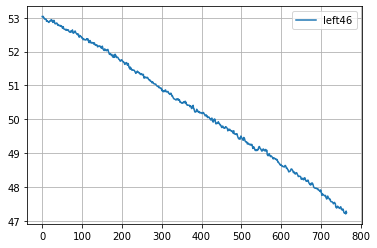

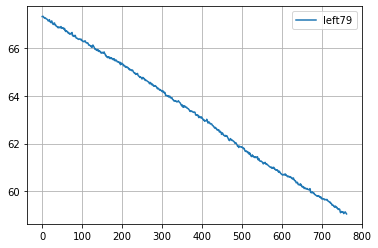

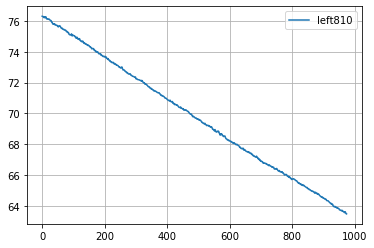

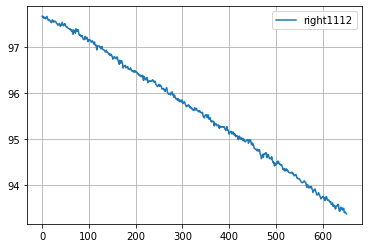

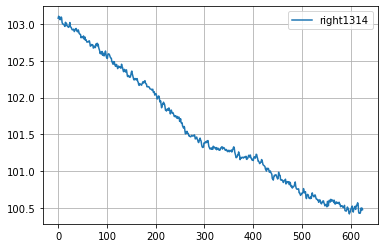

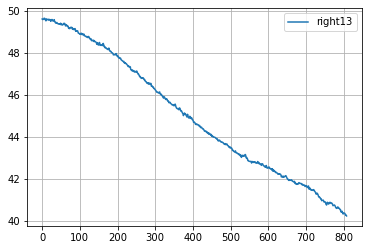

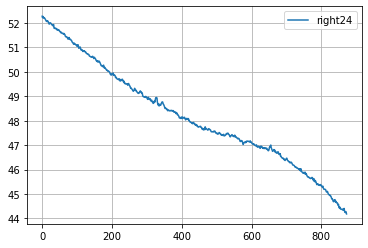

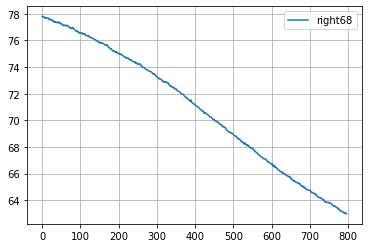

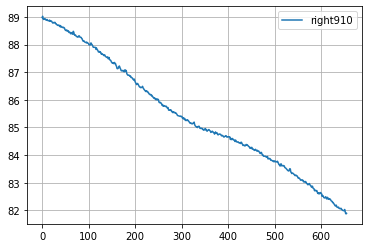

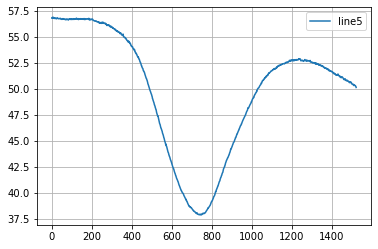

In [43]:
for line_name,line in ll.items():
    plt.plot(line.surf,label=line_name)
    plt.legend()
    plt.grid()
    plt.show()

In [39]:
width_0 = ll['line7'].loc[0].geometry.distance(ll['line7'].loc[1000].geometry)
width_6 = ll['line6'].loc[100].geometry.distance(ll['line6'].loc[1100].geometry)
width_0 = ll['line0'].loc[450].geometry.distance(ll['line0'].loc[1300].geometry)
print('width at line7 then 6 is about',width_0,width_6, width_0)

width at line7 then 6 is about 2549.5080094010377 2992.419410777798 2549.5080094010377


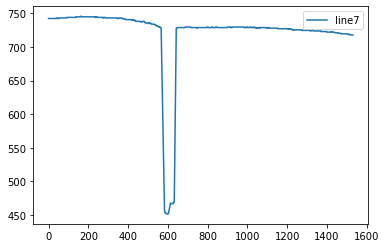

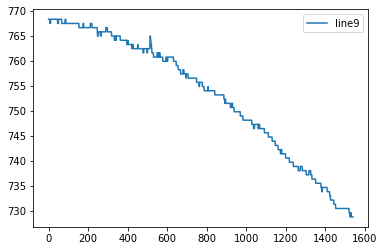

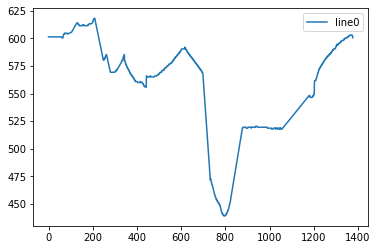

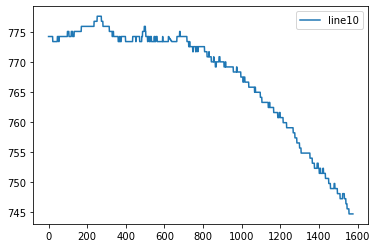

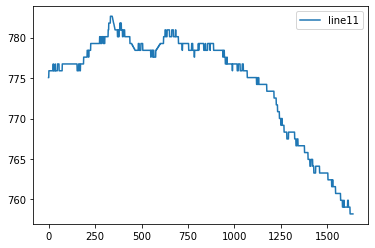

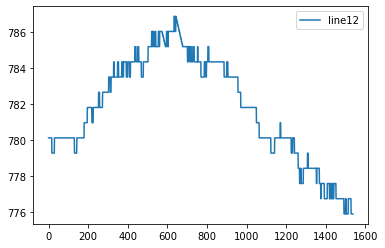

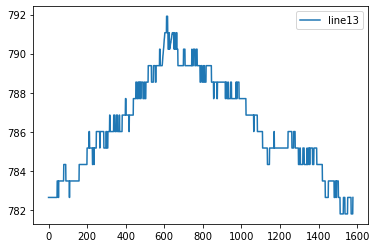

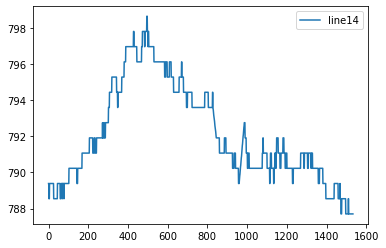

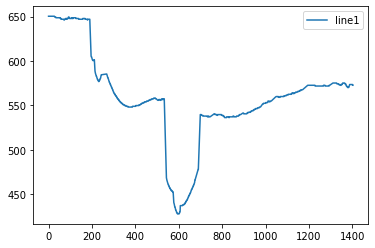

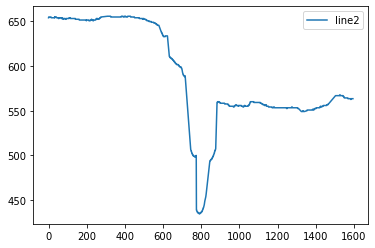

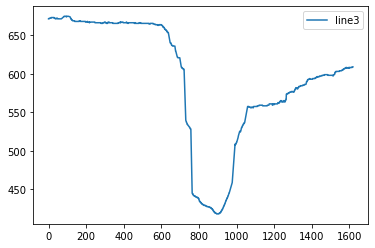

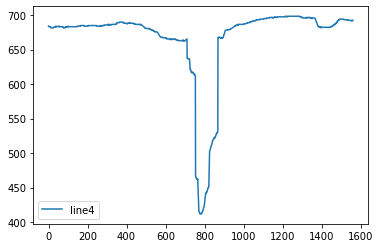

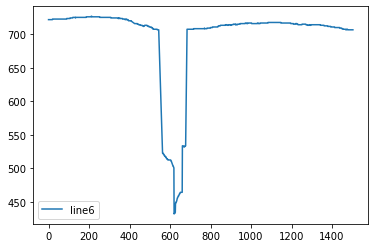

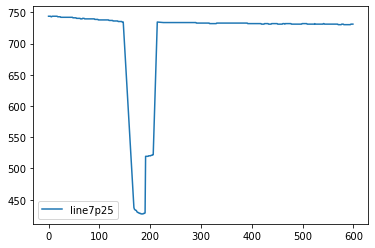

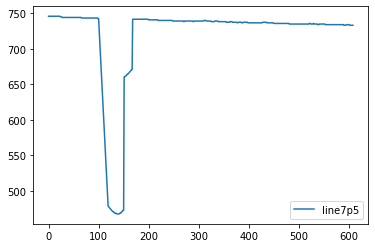

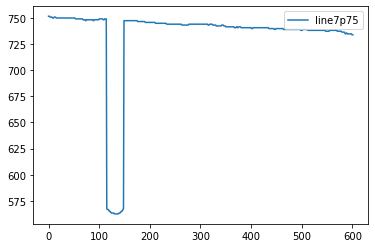

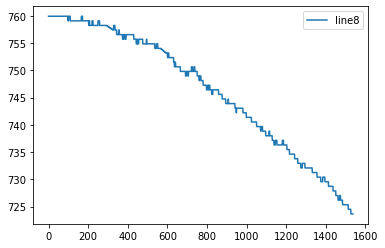

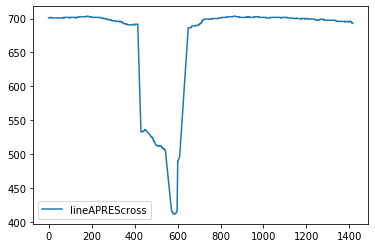

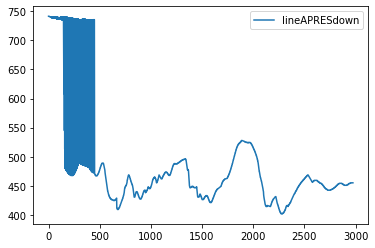

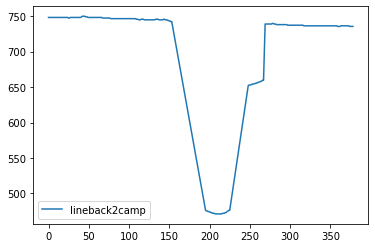

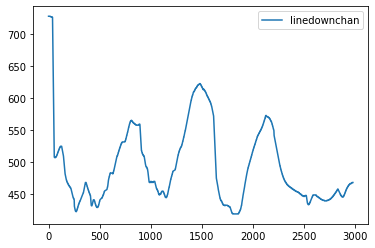

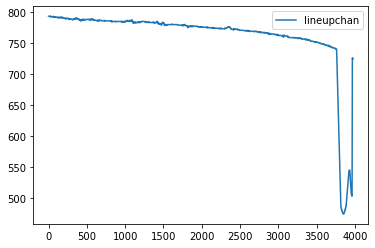

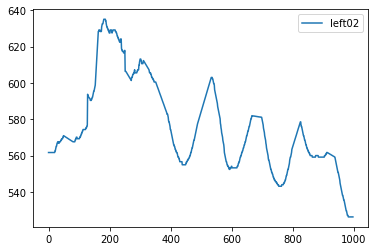

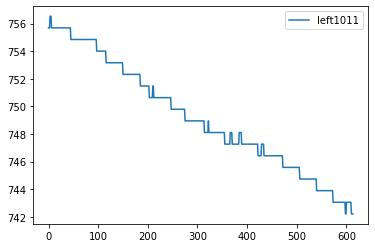

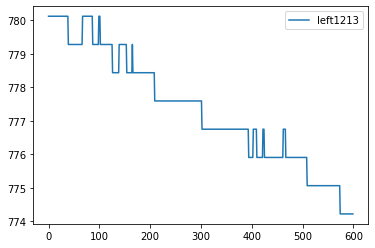

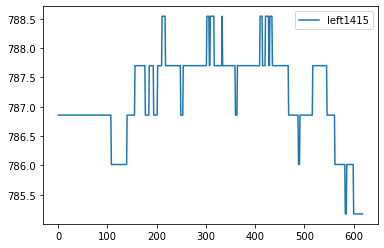

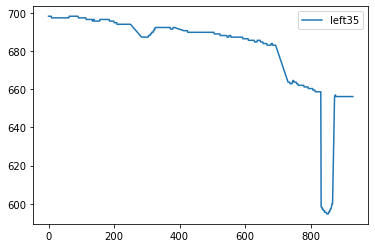

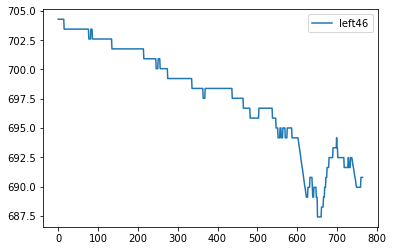

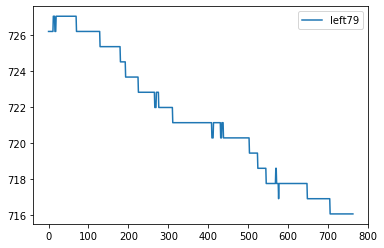

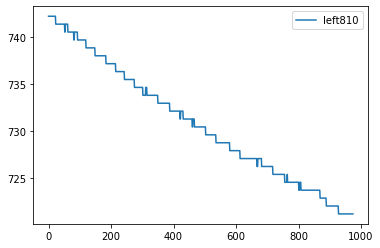

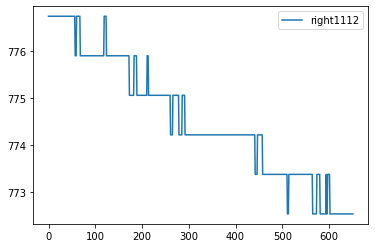

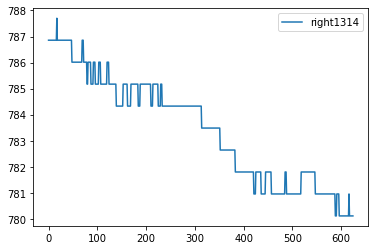

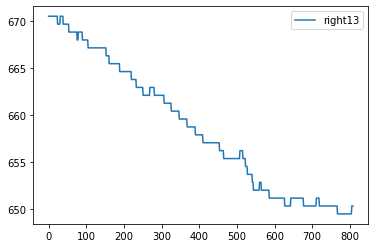

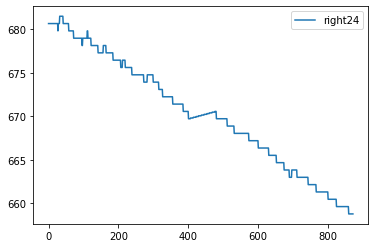

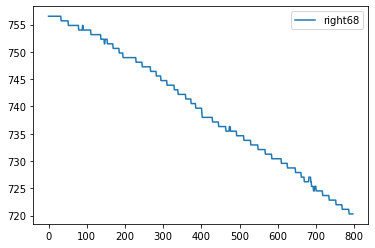

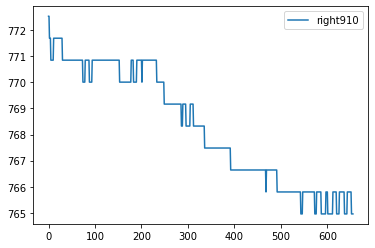

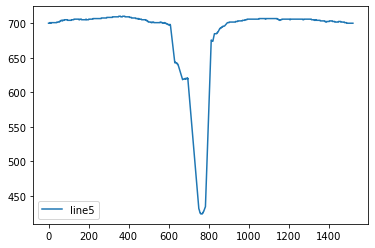

In [19]:
#depth of channel 100-300m
for line_name,line in ll.items():
    plt.plot(line.ice_thickn,label=line_name)
    plt.legend()
    plt.show()

In [32]:
#op = original points
ice_thickn_op = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/ice_thickn_channel.npy')
points_x_op = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/points_x_channel.npy')
points_y_op = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/points_y_channel.npy') 

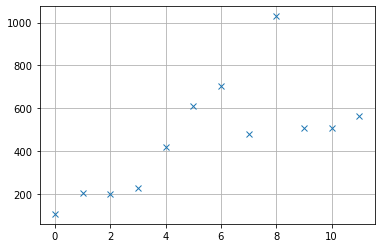

In [34]:
#width of channel
lhs =[Point(x,y) for x,y in zip(points_x_op[0,:],points_y_op[0,:])]
rhs=[Point(x,y) for x,y in zip(points_x_op[-1,:],points_y_op[-1,:])]
width = [l.distance(r) for l,r in zip(lhs,rhs)]
plt.plot(width,'x')
plt.grid()

In [23]:
x_new[0,:]

array([-381579.1       , -381562.11945716, -381543.82203319,
       -381524.30570977, -381503.6684686 , -381482.00829134,
       -381459.42315969, -381436.01105533, -381411.86995994,
       -381387.09785522, -381361.79272284, -381336.05254448,
       -381309.97530184, -381283.65897659, -381257.20155042,
       -381230.70100502, -381204.25532206, -381177.96248324,
       -381151.92047023, -381126.22385184, -381100.8938392 ,
       -381075.88103194, -381051.13316628, -381026.59797843,
       -381002.22320462, -380977.95658106, -380953.74652645,
       -380929.56410071, -380905.40770432, -380881.27737062,
       -380857.17313295, -380833.09502463, -380809.04307901,
       -380785.01732941, -380761.01780917, -380737.04455162,
       -380713.09759009, -380689.17695792, -380665.28268844,
       -380641.41481498, -380617.57337088, -380593.75838947,
       -380569.96990408, -380546.20794804, -380522.4725547 ,
       -380498.76375737, -380475.0815894 , -380451.42608411,
       -380427.79727485,

# find length of channel

In [15]:
mid_chan = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/SHARE_SHAPEFILES/interpolated_channel_mid.shp')

In [18]:
LineString(mid_chan.geometry.tolist()).length

10056.604069366851

# Find minimum ice thickness location and see if it corresponds with rema bullseye

In [26]:
#min is at index=39


## Draw 3D 'view' of channel

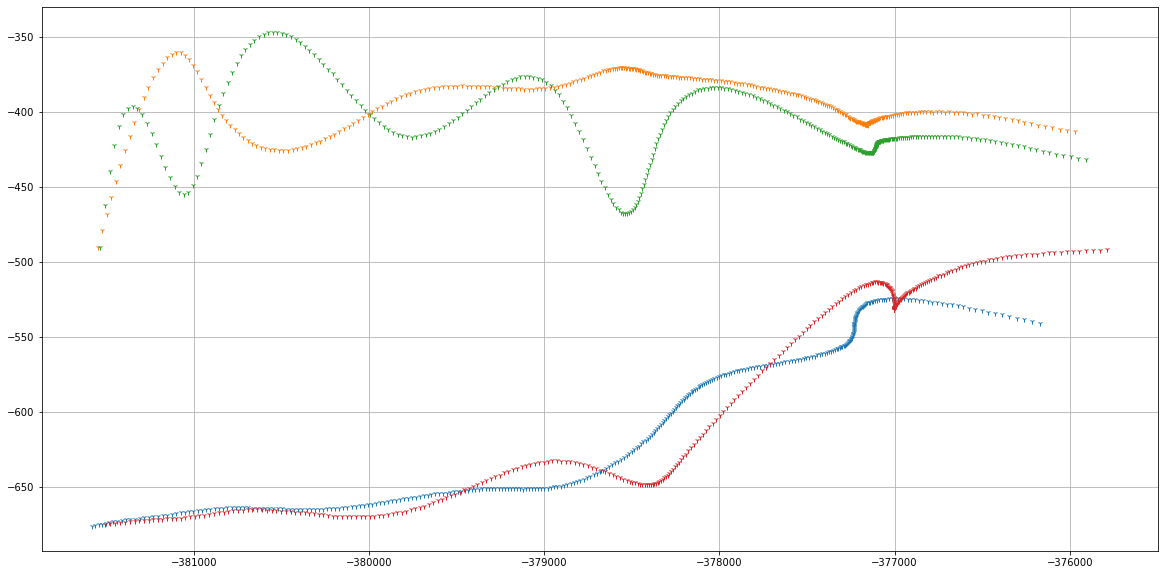

In [4]:
plt.figure(figsize=(20,10))
plt.plot(x_new[0,:],ib_new[0,:],'1')
plt.plot(x_new[10,:],ib_new[10,:],'1')
plt.plot(x_new[13,:],ib_new[13,:],'1')
plt.plot(x_new[-1,:],ib_new[-1,:],'1')
# plt.plot(x,it,'x')
plt.grid()
plt.show()

## Midchan colored over bullseye

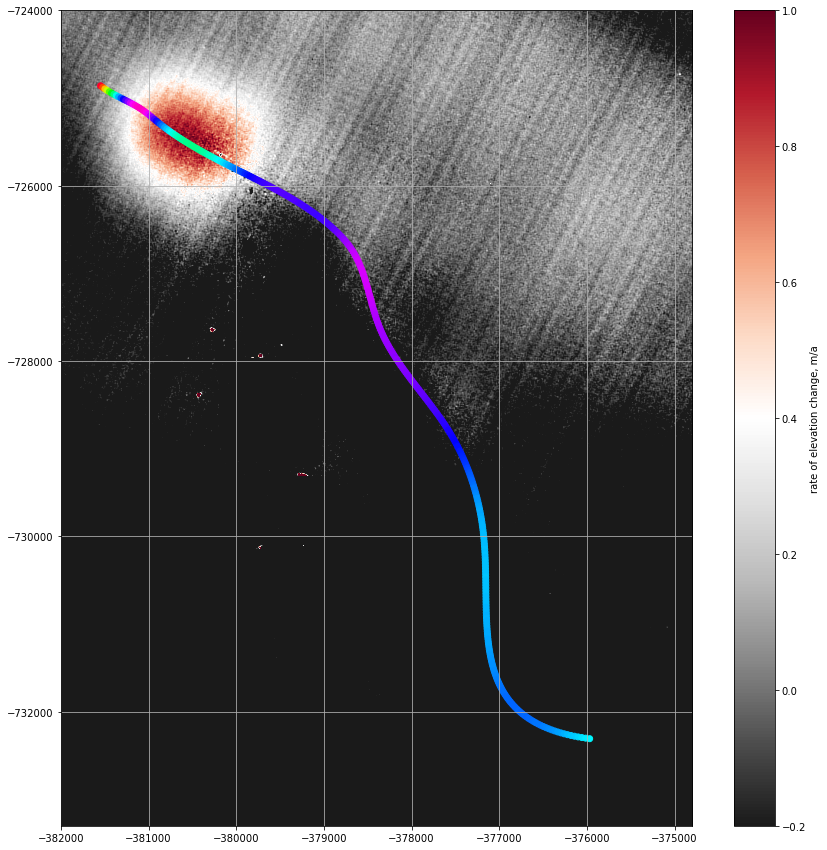

In [46]:
# %matplotlib qt
#rema
extent_REMA1 = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
plt.figure(figsize=(15,15))
GyRd = plt.cm.get_cmap('RdGy').reversed()
plt.imshow(im,extent=extent_REMAdiff, vmin=-0.2,vmax=1,cmap=GyRd)
cb = plt.colorbar()
cb.set_label('rate of elevation change, m/a')

plt.scatter(x_new[10,:],y_new[10,:],c=ib_new[10,:],cmap='gist_rainbow')


plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/bullseye_n_basecontour.png')
# cb2 = plt.colorbar()
# cb2.set_label('Elevation of ice underside, m')
plt.xlim([-382000, -374800])
plt.ylim([-733300,-724000])
plt.grid()
plt.show()